# slab seismicity





In [1]:
import sys     


path_to_pygplates = '/usr/lib/pygplates/revision18/'
path_to_local_scripts = './scripts/'

sys.path.insert(1, path_to_pygplates)
sys.path.insert(1, path_to_local_scripts)

path_to_input_data = './input_data/'

In [2]:
## Imports
%pylab inline

#Libraries
  
import glob
import numpy as np
import math
import time
import pandas as pd
import pickle as pkl



#Filtering
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import KDTree


#geometry and mapping
import pygplates
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

#earthquakes
import obspy
from obspy.imaging.beachball import beach
from obspy.imaging.beachball import beachball

#Locals
from tensor_tools import *
from geodesy import *
from utils import *
from rasters import *

Populating the interactive namespace from numpy and matplotlib


## parameters

In [31]:
#filters/smoothing

gf_slab_surf_points = 2
gf_slab_dip = 30

#megathrust identification
tensor_similarity = 0.75           #
megathrust_slab_top_limit = 20.    # (km) must be within this distant from slab top
megathrust_depth_limit = 70        # (km) must be less that this depth
megathrust_slab_dist_limit = 200   # (km) must be less that this distance from tranch
op_cutoff_distance = 5.



#for determining the relative plate motion azimuth, 
#used to determine rake (used by pygplates)
anchor_plate_id = 416   #Northeast Asia near Japan
moving_plate_id = 901   #Pacific


#set up some objects for convenience 

earth_radius_km = pygplates.Earth.mean_radius_in_kms
plot_extent = (133.0, 151.0, 30, 44.0)


land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])


## Load input data

In [5]:
#used by pygplates to get the subduction azimuth

rotation_filename = path_to_input_data + 'tectonic_data/Global_EarthByte_230-0Ma_GK07_AREPS.rot'


In [6]:
#load cmt and isc-ehb data

try:
    cat_0

except:
    #GCMT
    cat_0 = obspy.read_events(path_to_input_data + "/gcmts/JAPAN_NDK_bundle_2019-03-19T14.59.45.txt")
    #ISC-EHB
    cat_1 = obspy.read_events(path_to_input_data + '/isc-ehb/japan4+.xml')

## Load objects from 'create_profile_lines.ipynb'

In [7]:
load = True

if load:
    with open('./output_data/profile_lines_list.pkl','rb') as f:
        profile_lines_list_numpy = pkl.load(f)
    with open('./output_data/profile_distances_list.pkl','rb') as f:
        profile_distances_list = pkl.load(f)
    with open('./output_data/trench_points.pkl','rb') as f:
        trench_points  = pkl.load(f)
    with open('./output_data/trench_azimuths.pkl','rb') as f:
        trench_azimuths = pkl.load(f)
    with open('./output_data/profile_depths_list.pkl','rb') as f:
        profile_depths_list = pkl.load(f)
    with open('./output_data/domain_polygon_points.pkl','rb') as f:
            domain_polygon_points  = pkl.load(f)

In [8]:
#Recontruct some objects based on loaded data

profile_lines_list = [pygplates.PolylineOnSphere(pl) for pl in profile_lines_list_numpy]

# define trench normal 
trench_normal_azimuths = trench_azimuths  + 90.

#also define trench_normal CCW from 3 o'clock, for plotting on maps
trig_trench_normal_azimuths = 360. - (trench_normal_azimuths  - 90.)


domain_polygon = pygplates.PolygonOnSphere(pygplates.MultiPointOnSphere(domain_polygon_points
                                                                    ))

## convert the slab geometry to cartesian coords

In [9]:
#convert the slab geometry

profile_x_list = []
profile_y_list = []

for i in range(len(profile_distances_list))[:]:
    cart_distance, cart_depth = gca_radialdepth_to_cartesian(profile_distances_list[i], 
                                             profile_depths_list[i])
    
    profile_x_list.append(cart_distance)
    profile_y_list.append(cart_depth)
    
    
#also create earth surface in cartesian
lons_surf = np.deg2rad(np.linspace(-4, 10, 1000))

earth_surf_x = earth_radius_km*np.sin(lons_surf)
earth_surf_y = earth_radius_km - (earth_radius_km*np.cos(lons_surf))




#Create mean of interpolated slab surf across all/some of the profiles 

ps = 0
pe = -1

profile_x_mean  = np.mean(profile_x_list[ps:pe], axis = 0)
profile_y_mean  = np.nanmean(profile_y_list[ps:pe], axis = 0)

    

In [10]:
#interp_shift_output() takes a set of points representing a line in 2d, 
#it shifts them a given distance in a local normal direction (here zero shift is applied)
#it returns the location, cumulative arc distance (rel to trench), and dip (radians)


surface_x_list = []
surface_y_list = []
surface_dip_list = []
surface_arc_length_list = []


for i in range(len(profile_distances_list)):
                 
    dist_, dep_, arc_, dip_ = interp_shift_output(profile_x_list[i], 
                                          profile_y_list[i], 
                                          shift = 0.,
                                          coord_gauss = gf_slab_surf_points, 
                                          dip_angle_gauss = gf_slab_dip)
    
    surface_x_list.append(dist_)
    surface_y_list.append(dep_)
    surface_arc_length_list.append(arc_)
    surface_dip_list.append(dip_)
    
    


In [11]:
#plot dip vs arc length
#plt.plot(surface_arc_length_list[10], 
#         np.rad2deg(surface_dip_list[10]))

## process earthquake data

In [44]:
#pull out the hypocenter information, as we'll need numpy array access to these

#CMT
lons_0 = np.array(list(get_lon(cat_0))) 
lats_0 = np.array(list(get_lat(cat_0)))
depths_0 = get_depth(cat_0)*1e-3  #positive depth kms
mags_0 = np.array(list(get_mag(cat_0)))
time_0 = np.array([e.origins[0]['time'] for e in cat_0.events]) 


#ISC-EHB
lons_1 = np.array(list(get_lon(cat_1))) 
lats_1 = np.array(list(get_lat(cat_1)))
depths_1 = get_depth(cat_1)*1e-3  #positive depth kms
mags_1 = np.array(list(get_mag(cat_1)))
time_1 = np.array([e.origins[0]['time'] for e in cat_1.events]) 





#Hypocenter data from Tim
#this could be used to replace the ISC-EHB catalog as the source of hypocenter information

#date_cols = ['date', 'time']
#df = pd.read_csv('data/SelectedEarthquakes.txt', sep=' ')
#df['date_time'] = pd.to_datetime(df['date'] + ' ' + df['time'])


In [13]:
#Find which event epicenters are in the domain

regionmask_0  = np.array(indexes_points_in_polygons(lons_0, 
                                        lats_0, 
                                        domain_polygon))
regionmask_1  = np.array(indexes_points_in_polygons(lons_1, 
                                        lats_1, 
                                        domain_polygon))



In [14]:
#we limit analayis to the events in with t-axis and moment tensor

taxislist, taxisfoundlist  = get_axis_from_obs(cat_0, 
                                            whichaxis='t_axis')

mtlist, mtfoundlist = get_focmec_from_obs(cat_0)


#make sure both t-axes and mt 
with_mech_info = np.logical_and(taxisfoundlist, mtfoundlist)


#now add the with_mech_info mask to the region_mask0, 
#which now contains those events that are in the domain and have focal mech info

regionmask_0 = regionmask_0[with_mech_info[regionmask_0] == 1]


mtlist = np.array(mtlist)
taxislist = np.array(taxislist)

In [15]:
# now splice together the catalogs 

mask_0_1, mask_1_0 = catalog_time_comparison(time_0[regionmask_0], 
                                                       time_1[regionmask_1], 
                                                       tol_seconds=100)



lons =       lons_1[regionmask_1[mask_1_0]]
lats =       lats_1[regionmask_1[mask_1_0]]
depths =     depths_1[regionmask_1[mask_1_0]]
taxislist =  taxislist[regionmask_0[mask_0_1]]
mtlist =     mtlist[regionmask_0[mask_0_1]]
mags =       mags_1[regionmask_1[mask_1_0]]

## Map eqs to nearest epicentral point on profile lines

Each earthquake epicenter needs to be associated with the nearest point in the set of profile lines. This allows us to map the value of distance from the trench (known at each point on the profile lines) to the set of earthquake epicenters.

To do these we need two sets of indexes. For a given earthquake index in lons, lats etc:

* `im1` indexes into profile_line_list, providing the closest profile line to a given point(eq)
* `im2` indexes into a speficic point along the profile line. 

Hence for earthquake index `k`, with epicenter `(lons[k], lats[k])`, we would find the nearest point in the set of profile lines by using:

```
profile_lines_list[im1[k]][im2[k]]
```

The same scheme can be use for: `profile_depths_list`, `profile_distances_list`



In [16]:
#Im1 - index map 1, provides the closest profile line to a given point(eq)
#IM2 - index map2, provided the point index in that profile line


im1, im2 = map_points_to_profile_line(lons,
                                      lats, 
                                      profile_lines_list)


im1 = np.array(im1)
im2 = np.array(im2)

In [17]:
#point_distances_by_profile_line an map any quantity - should rename

eq_distance = point_distances_by_profile_line(profile_distances_list, 
                                                im1, 
                                                im2)




In [18]:
#values of distance to the trench and depth are effectively a polar coordinate system. 
#convert the earthquakes to cartesian coordinate system (x, y) 
#which has the origin at the trench, and a vertical axis parallel to the radial vector (down) at the trench. 

eq_x, eq_y = gca_radialdepth_to_cartesian(eq_distance, depths)


## Eq - slab surface spatial relationships

In this block we compare the earthquake locations (eq_x, eq_y) to the projected trace of the slab surface model. For each earthquake this builds up a set of information, which are srored in the arrays created (e.g. eq_surface_normal_length). The most important pieces of information are stored in the following arrays, which will allows is to plot the earthquakes in a "slab reference system"):


* eq_surface_normal_length => nearest distance from the earthquake to the projected trace of the slab surface model

* eq_surface_arc_length    => the downdip distance (arc length) at the nearest point on the slab surface model to the earthquake

In [19]:
#Set up empty arrays that have same shape as the eqs

eq_map_index_array = np.empty(len(lons))
eq_surface_normal_length = np.empty(len(lons))
eq_surface_arc_length = np.empty(len(lons))
eq_surface_dip = np.empty(len(lons))
eq_surface_x = np.empty(len(lons))
eq_surface_y = np.empty(len(lons))

for i in range(len(profile_lines_list)):
    eqswithindex = (np.array(im1) == i)
    if eqswithindex.sum():

        flatdist = surface_x_list[i]
        flatdepth = surface_y_list[i]

        testmask = np.invert(np.logical_or(np.isnan(flatdist), np.isnan(flatdepth)))

        tree =KDTree(np.column_stack((flatdist[testmask], 
                                      flatdepth[testmask])) )

        surface_dist, surface_indexes = tree.query(np.column_stack((eq_x[:][eqswithindex], 
                                       eq_y[:][eqswithindex])))

        
        #Now fill in the arrays for the set of eqs that are nearest to this (ith) profile line
        eq_map_index_array[eqswithindex] = surface_indexes
        eq_surface_normal_length[eqswithindex] = surface_dist
        eq_surface_arc_length[eqswithindex] =  surface_arc_length_list[i][surface_indexes]
        eq_surface_dip[eqswithindex] =  surface_dip_list[i][surface_indexes]
        eq_surface_x[eqswithindex] = surface_y_list[i][surface_indexes]
        eq_surface_y[eqswithindex] = surface_x_list[i][surface_indexes]
        
        

#The KDTree only gives absolute distances, 
#provide a signed distance by testing which earthquakes lie above the slab surface


main_eqs_above = eq_y < eq_surface_x 
eq_surface_normal_length[main_eqs_above]*=-1.

Text(0.5,0,'distance along slab surface (km)')

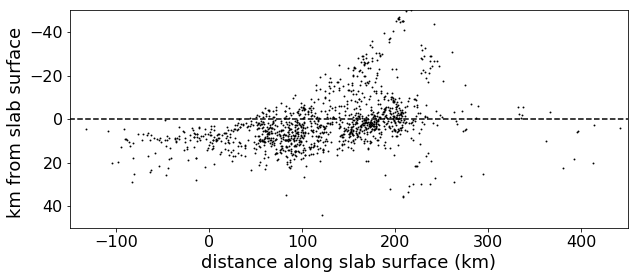

In [20]:
fig, ax = plt.subplots(figsize=(10,4))

ax.scatter(eq_surface_arc_length, 
           eq_surface_normal_length, c = 'k', s = 0.8 )




ax.set_xlim(-150, 450)

ax.hlines(0, -270, 1000, linestyles='--', colors='k')


ax.set_ylim(50,
            -50.)

ax.tick_params(labelsize=16)

ax.set_ylabel('km from slab surface ', size = 18)
ax.set_xlabel('distance along slab surface (km)', size = 18)

## Filter megathrust events

The preceedure is based on combination of hypocenter location (relative to the slab surface model) and moment tensor similarity (based on a DC tensor that slips on a plane given by the trench azimuth and dip), with a rupture direction (rake angle) provided by the relative velocity azimuth of the subducting plate and upper plate. 

In [47]:
#use pygplattes to get the relative velocity azimuth of the subducting plate and upper plate. 

rotation_model = pygplates.RotationModel(rotation_filename)

time_ = 0
time_step = 1



#Plate motion information
equivalent_stage_rotation = rotation_model.get_rotation(
    time_, moving_plate_id, time_+time_step, anchor_plate_id)


#get the relative velocity vector
eq_velocity_vector = pygplates.calculate_velocities(
        np.column_stack((lats, lons)),
        equivalent_stage_rotation,
        time_step,
        pygplates.VelocityUnits.cms_per_yr)

#convert the velocity vector to a convenient form
velocities  = np.array(pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
            np.column_stack((lats, lons)),
            eq_velocity_vector))



#define the azimuth of the trench associated with each eq, and the rake 

eq_trench_azimuths = trench_azimuths[im1]
eq_vel_azimuths = np.rad2deg(velocities[:,1])
eq_rakes = eq_trench_azimuths- (eq_vel_azimuths - 180.)

In [48]:
#Loop through the earthquakes, create a reference megthrust moment tensor, based on dip, rake, azimuth info
#compare the similarity of this tensor to the gcmt tensor and record the value in tensor_sim_list

tensor_sim_list = []

for i in range(len(lons)):
    
    mev = full_from_voight(mtlist[i])
    

    dip_  = np.rad2deg(eq_surface_dip[i])
    rake_ = eq_rakes[i]
    azimuth_ = eq_trench_azimuths[i]
        
    ref_mt_ = sdr2mtvect( azimuth_, 
                     dip_, 
                     rake_)
    ref_mt =  full_from_voight(ref_mt_)
        
    #if use_dc is True:
    mdev, mdc = dev_and_DC(mtlist[i])
    mev = mdc
    
    mev_norm= mev/np.linalg.norm(mev)
    tensor_prod = float(np.tensordot(mev_norm, ref_mt))
    tensor_sim_list.append(tensor_prod)
    

## Create masks for suspected megathurst, upper plate events

This section is pretty crude and could be redesigned. The masks are determined by several limits, which are provided in parameters section. 

In [49]:
megathrust_mask = np.logical_and( 
                                 #limit on tensor similarity 
                                 np.array(tensor_sim_list) > tensor_similarity, 
                   np.logical_and(
                   np.logical_and(
                                  #megathrust events must be shalllower than megathrust_depth_limi
                                  depths < megathrust_depth_limit, 
                                  #must be within a certain distance to the slab surface
                                  np.abs(eq_surface_normal_length) < megathrust_slab_top_limit), 
                                  #must be within this distance of the trench
                                  eq_x < megathrust_slab_dist_limit)) 
                                                          
                                                                                             
                                            


#Now try to capture upper plate events, using a single distance criteria
op_eq_mask = np.invert(eq_surface_normal_length > -op_cutoff_distance)


#combine the masks to provide a set of events that are likely to be slab earthquakes
slab_eq_mask = np.logical_and(np.invert(megathrust_mask), np.invert(op_eq_mask))

Text(0.5,0,'distance (km)')

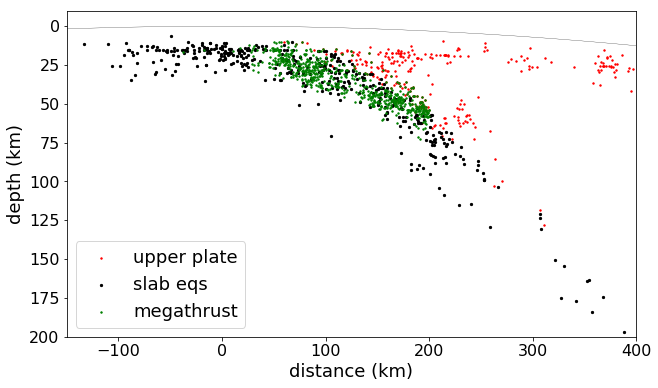

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(earth_surf_x, 
        earth_surf_y,  c= 'k', lw = 0.25)



ax.scatter(eq_x[op_eq_mask], eq_y[op_eq_mask],  
           s= 2, c = 'r', alpha = 1, label = 'upper plate')    

ax.scatter(eq_x[slab_eq_mask], eq_y[slab_eq_mask],  
           s= 5, c = 'k', alpha = 1, label = 'slab eqs') 
    

ax.scatter(eq_x[megathrust_mask], eq_y[megathrust_mask],  
           s= 2, c = 'g', alpha = 1, label = 'megathrust') 
    
    
ax.set_aspect(1.5)

ax.legend(loc=3, fontsize = 18)

ax.set_xlim(-150, 400)
ax.set_ylim(200,-10)

ax.tick_params(labelsize=16)
ax.set_ylabel('depth (km)', size = 18)
ax.set_xlabel('distance (km)', size = 18)

## Plot slab eq. t-axes

Text(0.5,0,'distance (km)')

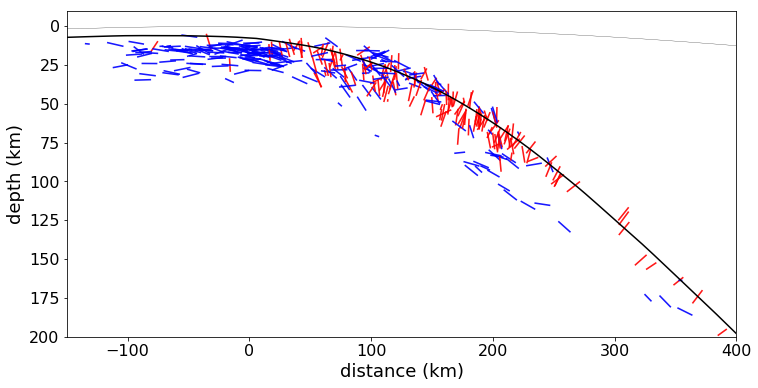

In [51]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(111)



ax.plot(earth_surf_x, 
        earth_surf_y,  c= 'k', lw = 0.25)



ax.plot(profile_x_mean, 
        profile_y_mean,
        c= 'k', label = 'SlabX model' , lw = 1.5)


for i in np.arange(len(lons))[slab_eq_mask]:
    

    #plot eqs in the 2d space of the great circle planes    
    depth_ = eq_y[i]
    horiz_ = eq_x[i]
    
    #the rotation of the t-axes requires azimuth and dip
    dip_ = np.rad2deg(eq_surface_dip[i])
    azim_ = eq_trench_azimuths[i]
    

        
    x, y = get_projected_axis(taxislist[i], 
                              azimuth_degrees= azim_ )
    
    
    #Figure out the coloring
    TM = coord_transform_matrix_2d(-1.*dip_)
    rot_taxis =  np.einsum("ij,j ->i", TM, [x, y])
    x_, y_ = rot_taxis[0], rot_taxis[1]
    c_ = 'r'
    normed_rot = rot_taxis/np.linalg.norm(rot_taxis)
    angle_bt = np.rad2deg(np.arccos(np.dot(normed_rot, [1, 0])))
    if (angle_bt) < 45 or (angle_bt) > 135:
        c_ = 'b'
        

        
    
    #This is a rotation of the t-axis that accuonts for the fact that the original moment tensor
    #is in a local tangent plabne coordinate syste, - down is radial down
    coord_fix_angle = np.rad2deg(eq_surface_y[i]/earth_radius_km)
    
    

    
    
    TM = coord_transform_matrix_2d(coord_fix_angle)
    rot_taxis =  np.einsum("ij,j ->i", TM, [x, y])
    x_, y_ = rot_taxis[0], rot_taxis[1]
    

    #if c_ == 'b':
    ax.quiver(horiz_ , depth_, x_, y_, scale = 0.075,angles = 'uv',units='xy',
                                          width = 1.25, alpha = 0.9,
                                          headlength=0., headwidth=0., 
                                      headaxislength=0, color=c_, pivot='mid')




    
ax.set_xlim(-150, 400)
ax.set_ylim(200,-10)

ax.tick_params(labelsize=16)
ax.set_ylabel('depth (km)', size = 18)
ax.set_xlabel('distance (km)', size = 18)


Text(0.5,0,'distance along slab surface (km)')

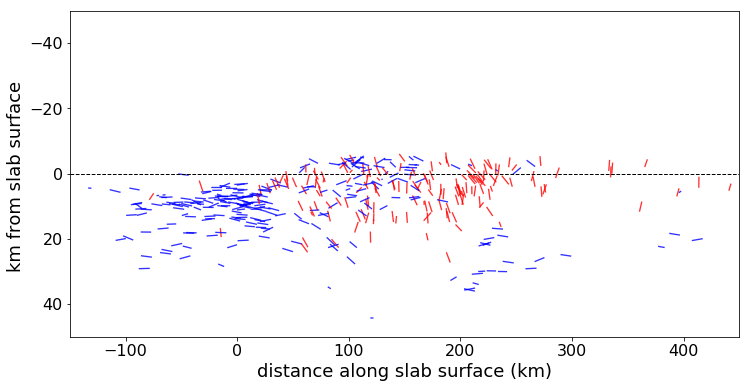

In [52]:

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(111)


for i in np.arange(len(lons))[slab_eq_mask]:
    

    #plot eqs in the slab reference frame
    vert_ = eq_surface_normal_length[i]
    horiz_ = eq_surface_arc_length[i]
    dip_ = np.rad2deg(eq_surface_dip[i])
    azim_ = eq_trench_azimuths[i]
    
    #the first rotation deals with the azimuth of the profile line
    x, y = get_projected_axis(taxislist[i], azimuth_degrees= azim_)
    

    
    #This is a rotation of the t-axis that accounts for the fact that the coord system for T axes 
    #includes the local radial direction
    
    coord_fix_angle = np.rad2deg(eq_surface_y[i]/6371.)

    
    
    TM = coord_transform_matrix_2d(-1.*dip_ + coord_fix_angle)
    rot_taxis =  np.einsum("ij,j ->i", TM, [x, y])
    x_, y_ = rot_taxis[0], rot_taxis[1]
    
    #saved_rotated_taxes.append((x_, y_))
    
    
    #Now figure out a color by determing if the rotated t axis lies within 45 of the [1,0] vector
    c_ = 'r'
    normed_rot = rot_taxis/np.linalg.norm(rot_taxis)
    angle_bt = np.rad2deg(np.arccos(np.dot(normed_rot, [1, 0])))
    if (angle_bt) < 45 or (angle_bt) > 135:
        c_ = 'b'

        
    ax.quiver(horiz_ , vert_, x_, y_, scale = 60,
                                          width = 0.002, alpha = 0.8,
                                          headlength=0., headwidth=0., 
                                      headaxislength=0, color=c_, pivot='mid')

    
ax.hlines(0, -150, 1000, linestyles='--', lw= 1)
ax.set_xlim(-150, 450)

ax.set_ylim(50,
            -50.)

ax.tick_params(labelsize=16)

ax.set_ylabel('km from slab surface ', size = 18)
ax.set_xlabel('distance along slab surface (km)', size = 18)

## Plot megathrust t-axes

Text(0.5,0,'distance (km)')

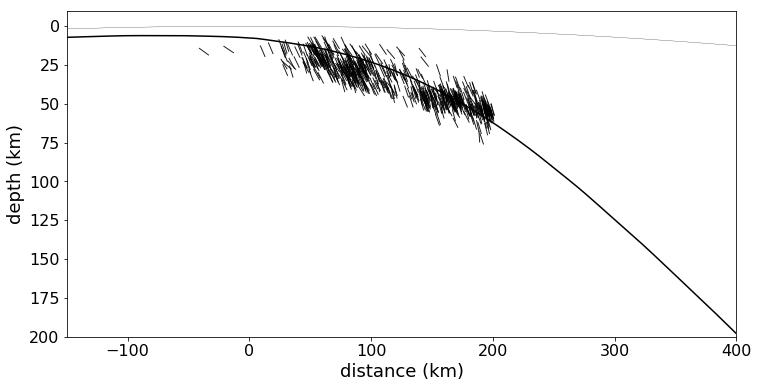

In [53]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(111)



ax.plot(earth_surf_x, 
        earth_surf_y,  c= 'k', lw = 0.25)


#ax.plot(slab2[:,0], 
#        slab2[:,1],
#        c= 'r', label = 'Slab2 model' , lw = 1.2)

ax.plot(profile_x_mean, 
        profile_y_mean,
        c= 'k', label = 'SlabX model' , lw = 1.5)


for i in np.arange(len(lons))[megathrust_mask]:
    

    #plot eqs in the 2d space of the great circle planes    
    depth_ = eq_y[i]
    horiz_ = eq_x[i]
    
    #the rotation of the t-axes requires azimuth and dip
    dip_ = np.rad2deg(eq_surface_dip[i])
    azim_ = eq_trench_azimuths[i]
    

        
    x, y = get_projected_axis(taxislist[i], 
                              azimuth_degrees= azim_ )
    

        
    #This is a rotation of the t-axis that accuonts for the fact that the original moment tensor
    #is in a local tangent plabne coordinate syste, - down is radial down
    coord_fix_angle = np.rad2deg(eq_surface_y[i]/earth_radius_km)    
    TM = coord_transform_matrix_2d(coord_fix_angle)
    rot_taxis =  np.einsum("ij,j ->i", TM, [x, y])
    x_, y_ = rot_taxis[0], rot_taxis[1]
    
    
    c_ = 'k'
    

    ax.quiver(horiz_ , depth_, x_, y_, scale = 0.1,angles = 'uv',units='xy',
                                          width = 0.75, alpha = 0.9,
                                          headlength=0., headwidth=0., 
                                      headaxislength=0, color=c_, pivot='mid')




    
ax.set_xlim(-150, 400)
ax.set_ylim(200,-10)

ax.tick_params(labelsize=16)
ax.set_ylabel('depth (km)', size = 18)
ax.set_xlabel('distance (km)', size = 18)

Text(0.5,0,'distance along slab surface (km)')

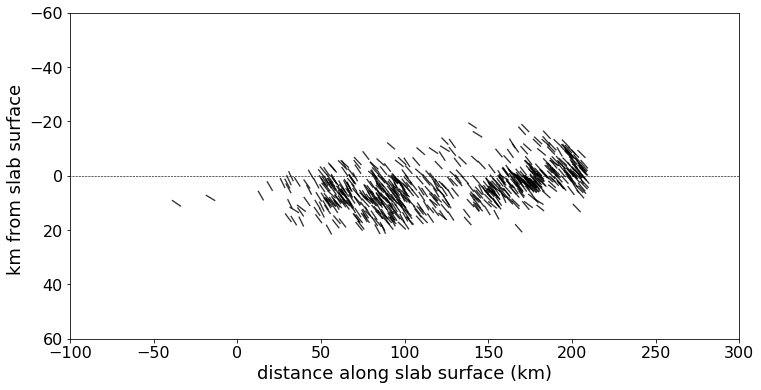

In [37]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(111)


for i in np.arange(len(lons))[megathrust_mask]:
    

    #plot eqs in the slab reference frame
    vert_ = eq_surface_normal_length[i]
    horiz_ = eq_surface_arc_length[i]
    dip_ = np.rad2deg(eq_surface_dip[i])
    azim_ = eq_trench_azimuths[i]
    
    #the first rotation deals with the azimuth of the profile line
    x, y = get_projected_axis(taxislist[i], azimuth_degrees= azim_)
    
    #This is a rotation of the t-axis that accounts for the fact that the coord system for T axes 
    #includes the local radial direction (NED)
    
    coord_fix_angle = np.rad2deg(eq_surface_y[i]/6371.)

    
    
    TM = coord_transform_matrix_2d(-1.*dip_ + coord_fix_angle)
    rot_taxis =  np.einsum("ij,j ->i", TM, [x, y])
    x_, y_ = rot_taxis[0], rot_taxis[1]
        
    c_ = 'k'
        
    ax.quiver(horiz_ , vert_, x_, y_, scale = 60,
                                          width = 0.002, alpha = 0.8,
                                          headlength=0., headwidth=0., 
                                      headaxislength=0, color=c_, pivot='mid')

    
ax.hlines(0, -150, 1000, linestyles='--', lw= 0.6)
ax.set_xlim(-100, 300)
ax.set_ylim(60, -60)

ax.tick_params(labelsize=16)

ax.set_ylabel('km from slab surface ', size = 18)
ax.set_xlabel('distance along slab surface (km)', size = 18)